In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt, exp, pi
from sklearn.naive_bayes import GaussianNB
from scipy.stats import weibull_min, weibull_max, genextreme
import itertools

In [2]:
nb_training = 5

all_frames_uniform = [1, 2, 4, 5, 6, 36, 38, 40, 42, 45, 47, 50, 52, 55, 57, 60, 62, 65, 67, 70,
                      72, 74, 76, 78, 80, 84, 86, 87, 100, 142]

all_frames_enriched = [1, 2, 4, 5, 6, 36, 38, 40, 42, 45, 47, 50, 52, 55, 57, 60, 62, 65, 67, 70,
                      72, 74, 76, 78, 80, 86, 101, 111, 121, 132]

human_test_ind = [36, 38, 40, 42, 45, 47, 50, 52, 55, 57, 60, 62, 65, 67, 70, 72, 74, 76, 78, 80,]

human_uniform_prob = [0.074786, 0.057692, 0.066239, 0.104701, 0.123932,
                      0.188034, 0.258547, 0.388889, 0.485043, 0.602564,
                      0.690171, 0.782051, 0.856838, 0.884615, 0.899573,
                      0.931624, 0.938034, 0.955128, 0.950855, 0.972222]
human_enrich_prob = [0.119048, 0.062907, 0.075922, 0.097614, 0.132321,
                     0.201735, 0.288503, 0.392625, 0.496746, 0.613883,
                     0.722343, 0.800434, 0.872017, 0.924078, 0.952278,
                     0.952278, 0.958696, 0.976087, 0.973913, 0.980435]

In [3]:
# Calculate the mean of a list of numbers
def mean(numbers):
    return sum(numbers)/float(len(numbers))




# Calculate the standard deviation of a list of numbers
def stdev(numbers):
    avg = mean(numbers)
    variance = sum([(x-avg)**2 for x in numbers]) / float(len(numbers)-1)
    return sqrt(variance)




# Calculate the Gaussian probability distribution function for x
def calculate_probability(x, mean, stdev):
    exponent = exp(-((x-mean)**2 / (2 * stdev**2 )))
    # print((1 / (sqrt(2 * pi) * stdev)) * exponent)
    return (1 / (sqrt(2 * pi) * stdev)) * exponent



def get_prob(data_frame,
             classifier):
    """

    :param data_frame:
    :return:
    """
    sample_w_frame = data_frame[["frame", "distance_to_A"]]
    frames = sample_w_frame['frame'].unique()

    prob_dict = {}
    prob_one_frame = []

    for one_frame in frames:
        frames = sample_w_frame.loc[sample_w_frame['frame'] == one_frame]
        dist = frames["distance_to_A"].tolist()

        for one_dist in dist:
            prob = classifier.predict_proba(np.asarray(one_dist).reshape(-1, 1))
            prob_one_frame.append(prob[0][1])

        prob_dict[one_frame] = mean(prob_one_frame)

    return prob_dict

In [4]:
def gaussian_naive_bayes(data_dir):
    """
    Use class A and class B training data to fit a gaussian model,
    then use bayesian theorem to calculate probability.

    :return:
    """
    # Step 1: Load training data for class A and B, and testing data
    training_a = pd.read_csv(os.path.join(data_dir, "sample_a.csv"))
    training_b = pd.read_csv(os.path.join(data_dir, "sample_b.csv"))
    testing = pd.read_csv(os.path.join(data_dir, "test_samples.csv"))

    # Take feature column for training data and convert data to list
    a_sample = training_a[["distance_to_A"]]
    b_sample = training_b[["distance_to_A"]]

    a_sample = a_sample.distance_to_A.values.tolist()
    b_sample = b_sample.distance_to_A.values.tolist()

    print("Number of samples in class A:", len(a_sample))
    print("Number of samples in class B:", len(b_sample))

    # Step 2: Calculate mean and standard deviation
    mean_a = mean(a_sample)
    sd_a = stdev(a_sample)
    var_a = np.var(np.asarray(a_sample))

    mean_b = mean(b_sample)
    sd_b = stdev(b_sample)
    var_b = np.var(np.asarray(b_sample))

    print("Mean for A: ", mean_a)
    print("SD for A: ", sd_a)
    print("Var for A: ", var_a )
    print("Mean for B: ", mean_b)
    print("SD for B :", sd_b)
    print("Var for B: ", var_b)

    stats = [mean_a, sd_a, var_a, mean_b, sd_b, var_b]

    """
    # Ignore these for now - JH
    
    # Step 3: Gaussian Probability Density Function.
        # -- defined above

    # Step 4: Class Probabilities -- P(class|data) = P(X|class) * P(class)
    # Calculate avg prob of choosing B for each frame, respectively
    """

    # Build and fit Gaussian Naive Bayes Model
    clf = GaussianNB()

    X = np.asarray(a_sample + b_sample)
    Y = np.asarray([0] * len(a_sample) + [1] * len(b_sample))
    clf.fit(X.reshape(-1, 1), Y)

    # Training data A
    prob_dict_a = get_prob(data_frame=training_a,
                            classifier=clf)

    # Training data B
    prob_dict_b = get_prob(data_frame=training_b,
                           classifier=clf)

    # Testing data
    prob_dict_test = get_prob(data_frame=testing,
                         classifier=clf)

    # Combine dictionaries and sort
    prob_dict = {**prob_dict_a, **prob_dict_b, **prob_dict_test}
    prob_dict = dict(sorted(prob_dict.items()))

    # print(prob_dict)

    return prob_dict, stats

In [5]:
def evt_fit(data,
            distribution,
            tail_choice,
            tail_ratio):
    """

    :param data: Sampled data
    :param distribution: Weibull or reversed Weibull
    :param tail_choice:
        right - fit tails taken from the right side of sorted samples
        left - fit tails from left side. Scores are flipped by doing (max_score - current_score)
    :param tail_ratio: larger than 0.0, smaller or equal to 0.5
    :return:
    """
    # Format data
    sample = data[["distance_to_A"]]
    sample = sample.distance_to_A.values.tolist()

    # Find the tail samples we will use to fit model
    nb_tail = int(len(sample) * tail_ratio)
    sample = sorted(sample)

    if tail_choice == "right":
        tail_samples = sample[-nb_tail:]

    elif tail_choice == "left":
        tail_samples = sample[:nb_tail]

    else:
        raise Exception('Tail choice not implemented. Choose from left or right.')

    # Fit EVT models
    if distribution == "weibull":
        shape, loc, scale = weibull_min.fit(tail_samples)
        return shape, loc, scale

    elif distribution == "reversed_weibull":
        shape, loc, scale = weibull_max.fit(tail_samples)
        return shape, loc, scale

    else:
        raise Exception('Distribution not implemented.')

In [6]:
def evt_predict(data,
                shape,
                loc,
                scale,
                distribution):
    """

    :param data:
    :param shape:
    :param loc:
    :param scale:
    :return:
    """
    sample_w_frame = data[["frame", "distance_to_A"]]
    frames = sample_w_frame['frame'].unique()

    # print("Frames in: ", frames)

    prob_dict = {}
    prob_one_frame = []

    for one_frame in frames:
        frames = sample_w_frame.loc[sample_w_frame['frame'] == one_frame]
        dist = frames["distance_to_A"].tolist()

        for one_dist in dist:
            if distribution == "weibull":
                prob = weibull_min.cdf(one_dist, shape, loc, scale)
            elif distribution == "reversed_weibull":
                prob = weibull_max.cdf(one_dist, shape, loc, scale)
            else:
                raise Exception('Distribution not implemented.')

            prob_one_frame.append(prob)

        prob_dict[one_frame] = mean(prob_one_frame)

    return prob_dict

In [7]:
def evt_model(data_dir,
              tail_type,
              tail_ratio,
              distribution,
              sampling,
              params=None,
              fit_curve=False,):
    """

    :return:
    """

    # Load training data for class A and B, and testing data
    training_a = pd.read_csv(os.path.join(data_dir, "sample_a.csv"))
    training_b = pd.read_csv(os.path.join(data_dir, "sample_b.csv"))
    testing = pd.read_csv(os.path.join(data_dir, "test_samples.csv"))
    
    print(training_b.shape)

    """
    Fit a distribution, currently choose between "weibull" and "reversed_weibull".
    
    weibull: weibull_min. When data is bounded from below.
    reversed weibull:weibull_max. When data is bounded from above.
    
    fit func returns shape, location and scale parameters
    """
    if fit_curve:
        shape_a, loc_a, scale_a = evt_fit(data=training_a,
                                          distribution=distribution,
                                          tail_choice=tail_type,
                                          tail_ratio=tail_ratio)

        shape_b, loc_b, scale_b = evt_fit(data=training_b,
                                          distribution=distribution,
                                          tail_choice=tail_type,
                                          tail_ratio=tail_ratio)

    else:
        """
        Use the parameters for our testing samples.
        Probability for each sample is produced by CDF func.
        """
        shape_b = params[0]
        scale_b = params[1]
        loc_b = params[2]
        
        prob_dict_a = evt_predict(data=training_a,
                         shape=shape_b,
                         loc=loc_b,
                         scale=scale_b,
                         distribution="weibull")
        
        # EVT Uniform
        if sampling == "uniform":
            prob_dict_b = evt_predict(data=training_b,
                                     shape=shape_b,
                                     loc=loc_b,
                                     scale=scale_b,
                                     distribution="weibull")

        
        # EVT enriched tail
        else:
            # First, calculate how many samples we will use based on tail size
            nb_sample = int(tail_ratio * training_b.shape[0])
            print("nb_sample for B: ", nb_sample)
            
            # Then, use tail type to decide what samples we are taking
            if tail_type == "left":
                print("Tail type: ", tail_type)
                data_for_b = training_b[:nb_sample]
            
            elif tail_type == "right":
                print("Tail type: ", tail_type)
                data_for_b = training_b[-nb_sample:]
            else:
                # enriched
                print("Tail type: ", tail_type)
                data_for_b_left = training_b[:int(0.5*nb_sample)]
                data_for_b_right = training_b[-int(0.5*nb_sample):]
                frames = [data_for_b_left, data_for_b_right]
                data_for_b = pd.concat(frames)
                
            print(data_for_b.shape)
            prob_dict_b = evt_predict(data=data_for_b,
                                     shape=shape_b,
                                     loc=loc_b,
                                     scale=scale_b,
                                     distribution="weibull")
            
        
        prob_dict_test = evt_predict(data=testing,
                        shape=shape_b,
                        loc=loc_b,
                        scale=scale_b,
                        distribution="weibull")

        prob_dict = {**prob_dict_a, **prob_dict_b, **prob_dict_test}
        prob_dict = dict(sorted(prob_dict.items()))

    # print(prob_dict)
    # print(shape_b, scale_b, loc_b)

    return prob_dict

In [8]:
def plot_prob_curve(gaussian_prob_uniform,
                    gaussian_prob_enrich,
                    evt_prob_uniform,
                    evt_prob_enrich,
                    human_data_uniform,
                    human_data_enrich,):
    """

    :param prob:
    :return:
    """
    from matplotlib.pyplot import figure

    figure(figsize=(8, 6), dpi=80)
    
    # Gaussian probabilities for uniform and enriched tail
    list_gauss_uniform = sorted(gaussian_prob_uniform.items())
    x_gauss_uniform, y_gauss_uniform = zip(*list_gauss_uniform)

    list_gauss_enrich = sorted(gaussian_prob_enrich.items())
    x_gauss_enrich, y_gauss_enrich = zip(*list_gauss_enrich)

    # EVT probabilities for uniform and enriched tail
    list_evt_uniform = sorted(evt_prob_uniform.items())
    x_evt_uniform, y_evt_uniform = zip(*list_evt_uniform)

    list_evt_enrich = sorted(evt_prob_enrich.items())
    x_evt_enrich, y_evt_enrich = zip(*list_evt_enrich)

    # Plot 6 curves
    plt.plot(x_gauss_uniform[5:25], y_gauss_uniform[5:25], label="Gaussain Uniform", color='red',)
    plt.plot(x_gauss_uniform[5:25], y_gauss_enrich[5:25], label="Gaussain Enriched Tail", color='red', linestyle=':',)
    plt.plot(x_gauss_uniform[5:25], y_evt_uniform[5:25], label="EVT Uniform", color='blue')
    plt.plot(x_gauss_uniform[5:25], y_evt_enrich[5:25], label="EVT Enriched Tail", color='blue', linestyle=':',)
    plt.plot(human_test_ind, human_data_uniform , label="Human Uniform", color='green')
    plt.plot(human_test_ind, human_data_enrich , label="Human Enriched Tail", color='green', linestyle=':',)

    plt.legend(loc="lower right")

#     if not os.path.isdir(os.path.join(save_fig_dir, model)):
#         os.mkdir(os.path.join(save_fig_dir, model))

#     save_fig_path = save_fig_dir + "/" + model + "/tail_ratio_" + str(params[-1]) + \
#                     "_shape_" + str(params[0]) + \
#                     "_scale_" + str(params[1]) + "_loc_" + str(params[2]) + ".png"

#     plt.savefig(save_fig_path)
#     plt.clf()

In [9]:
# VGG-ResNet
uniform_data_dir = "/Users/kiyoshi/Desktop/jov_everything/face_morph_v4_5_sets_modeling/vggface_resnet_uniform_nb_train_5_ratio_0.9_tail_weight_0.4"
enriched_tail_data_dir = "/Users/kiyoshi/Desktop/jov_everything/face_morph_v4_5_sets_modeling/vggface_resnet_enriched_tail_nb_train_5_ratio_0.9_tail_weight_0.4"

In [10]:
# Gaussian
gaussian_prob_uniform, stats_uniform = gaussian_naive_bayes(data_dir=uniform_data_dir)
print("Uniform Gaussian prob from sklearn:")
print(gaussian_prob_uniform)

gaussian_prob_enrich, stats_enrich = gaussian_naive_bayes(data_dir=enriched_tail_data_dir)
print("Enriched tail Gaussian prob from sklearn:")
print(gaussian_prob_enrich)

Number of samples in class A: 405
Number of samples in class B: 405
Mean for A:  3.703616092234482
SD for A:  2.2775912337308784
Var for A:  5.174613379009806
Mean for B:  61.67699843983591
SD for B : 10.757943879829265
Var for B:  115.44759514742863
Uniform Gaussian prob from sklearn:
{1: 8.717990047646068e-07, 2: 1.310764017259706e-07, 4: 7.459207920710758e-07, 5: 1.1575879283643508e-06, 6: 1.432046569774354e-06, 36: 0.9861240238801137, 38: 0.9882920004641657, 40: 0.9910606247692215, 42: 0.9929742464855039, 45: 0.9943763365337283, 47: 0.9953131156605974, 50: 0.9959826700387864, 52: 0.9964848362692685, 55: 0.9968754100170217, 57: 0.9971878690153178, 60: 0.9974435172866525, 62: 0.9976565575127648, 65: 0.9978368223194752, 67: 0.9979913350109413, 70: 0.9981252460102119, 72: 0.9982424181345736, 74: 0.9983458053031281, 76: 0.9984377050085099, 78: 0.9985199310606936, 80: 0.9985939345076589, 84: 1.0, 86: 1.0, 87: 1.0, 100: 1.0, 142: 1.0}
Number of samples in class A: 405
Number of samples in

(405, 5)
(405, 5)
nb_sample for B:  202
Tail type:  left
(202, 5)


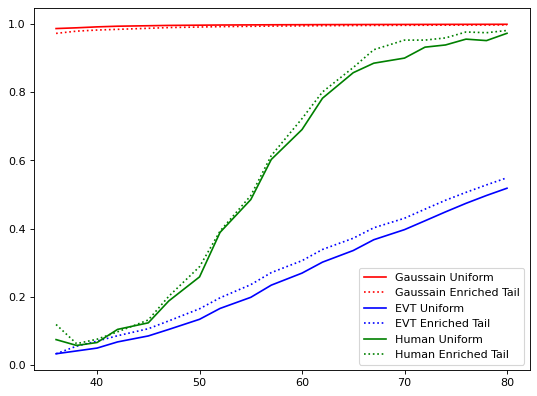

In [11]:
# EVT 
shape_uniform = 9.0
scale_uniform = 0.2
location_uniform = 40

shape_enrich = 100.0
scale_enrich = 0.1
location_enrich = 39

tail_type = "left"
tail_size = 0.5

# EVT model and prediction for uniform
evt_prob_uniform = evt_model(data_dir=uniform_data_dir,
                             distribution="weibull",
                             tail_ratio=None,
                             tail_type=None,
                             sampling="uniform",
                             params=[shape_uniform, scale_uniform, location_uniform],
                             fit_curve=False)

# EVT model and prediction for enriched tail
evt_prob_enrich = evt_model(data_dir=enriched_tail_data_dir,
                             distribution="weibull",
                             sampling="enrich",
                             tail_ratio=tail_size,
                             tail_type=tail_type,
                             params=[shape_enrich, scale_enrich, location_enrich],
                             fit_curve=False)

plot_prob_curve(gaussian_prob_uniform=gaussian_prob_uniform,
                gaussian_prob_enrich=gaussian_prob_enrich,
                evt_prob_uniform=evt_prob_uniform,
                evt_prob_enrich=evt_prob_enrich,
                human_data_uniform=human_uniform_prob,
                human_data_enrich=human_enrich_prob)

# Split results into 3 panels

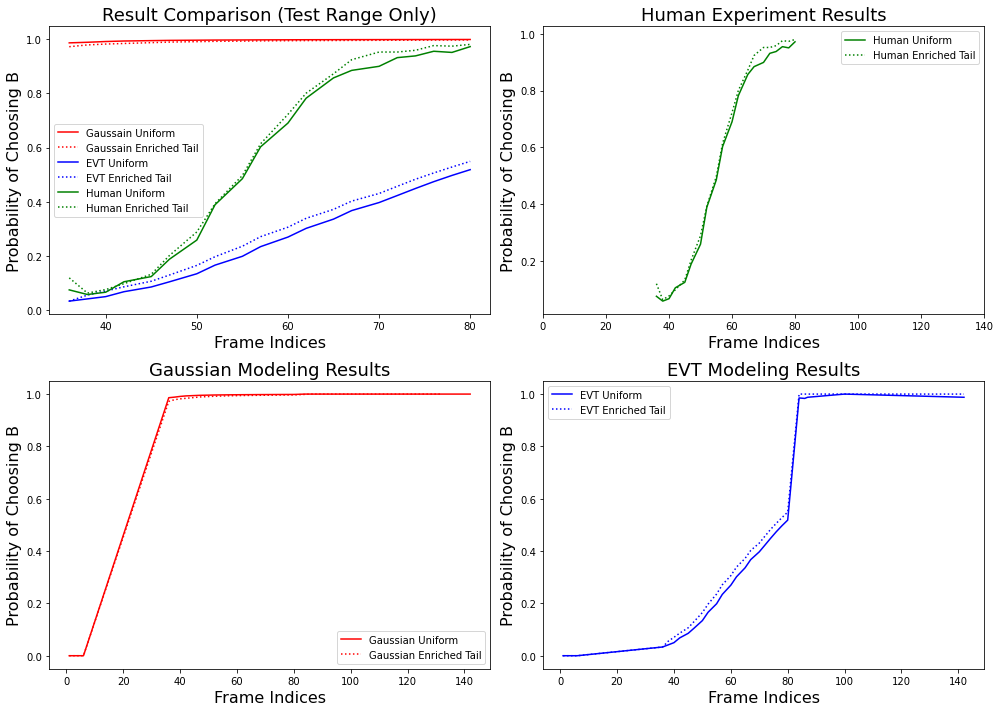

In [17]:
# Create the figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axes = axes.flatten()

title_fontsize = 18
label_fontsize = 16
text_fontsize = 16

# Gauss
list_gauss_uniform = sorted(gaussian_prob_uniform.items())
x_gauss_uniform, y_gauss_uniform = zip(*list_gauss_uniform)

list_gauss_enrich = sorted(gaussian_prob_enrich.items())
x_gauss_enrich, y_gauss_enrich = zip(*list_gauss_enrich)

# EVT
list_evt_uniform = sorted(evt_prob_uniform.items())
x_evt_uniform, y_evt_uniform = zip(*list_evt_uniform)

list_evt_enrich = sorted(evt_prob_enrich.items())
x_evt_enrich, y_evt_enrich = zip(*list_evt_enrich)

# Sample data
# axes[0].text(5, 0.5, "To resemble the NSF figure, this is a placeholder for stumuli", fontsize=12, color="green", ha="center")

# axes[0].set_title("To resemble the NSF figure,\n this is a placeholder for stumuli", fontsize=title_fontsize)
axes[0].plot(x_gauss_uniform[5:25], y_gauss_uniform[5:25], label="Gaussain Uniform", color='red',)
axes[0].plot(x_gauss_uniform[5:25], y_gauss_enrich[5:25], label="Gaussain Enriched Tail", color='red', linestyle=':',)
axes[0].plot(x_gauss_uniform[5:25], y_evt_uniform[5:25], label="EVT Uniform", color='blue')
axes[0].plot(x_gauss_uniform[5:25], y_evt_enrich[5:25], label="EVT Enriched Tail", color='blue', linestyle=':',)
axes[0].plot(human_test_ind, human_uniform_prob , label="Human Uniform", color='green')
axes[0].plot(human_test_ind, human_enrich_prob , label="Human Enriched Tail", color='green', linestyle=':',)
axes[0].set_title("Result Comparison (Test Range Only)", fontsize=title_fontsize)
axes[0].set_xlabel("Frame Indices", fontsize=label_fontsize)
axes[0].set_ylabel("Probability of Choosing B", fontsize=label_fontsize)
axes[0].legend()
# axes[1].legend()


# Plot on each subplot
# Human
axes[1].plot(human_test_ind, human_uniform_prob, label="Human Uniform", color="green")
axes[1].plot(human_test_ind, human_enrich_prob, label="Human Enriched Tail",linestyle=':', color="green")
axes[1].set_title("Human Experiment Results", fontsize=title_fontsize)
axes[1].set_xlabel("Frame Indices", fontsize=label_fontsize)
axes[1].set_ylabel("Probability of Choosing B", fontsize=label_fontsize)
axes[1].set_xlim(0, 140) 
axes[1].legend()


axes[2].plot(x_gauss_uniform, y_gauss_uniform, label="Gaussian Uniform", color="red")
axes[2].plot(x_gauss_enrich, y_gauss_enrich, label="Gaussian Enriched Tail", linestyle=':', color="red")
axes[2].set_title("Gaussian Modeling Results", fontsize=title_fontsize)
axes[2].set_xlabel("Frame Indices", fontsize=label_fontsize)
axes[2].set_ylabel("Probability of Choosing B", fontsize=label_fontsize)
axes[2].legend()


axes[3].plot(x_gauss_uniform, y_evt_uniform, label="EVT Uniform", color="blue")
axes[3].plot(x_gauss_uniform, y_evt_enrich, label="EVT Enriched Tail", linestyle=':', color="blue")
axes[3].set_title("EVT Modeling Results", fontsize=title_fontsize)
axes[3].set_xlabel("Frame Indices", fontsize=label_fontsize)
axes[3].set_ylabel("Probability of Choosing B", fontsize=label_fontsize)
axes[3].legend()

# Adjust layout
plt.tight_layout()

# Show the figure
plt.show()